# Adaptive exponential integrate-and-fire model fit to HH with Nevergrad

In [1]:
from brian2 import *
from brian2tools import *

prefs.codegen.target = 'cython'  # weave is not multiprocess-safe!

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]


## HH

In [2]:
# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
VT = -63*mV

dt = 0.01*ms

In [3]:
# Generate a step-current input and an "experimental" voltage trace
input_current = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt)), np.zeros(int(5*ms/dt))])*2*nA

params_correct = {'gl': float(5e-5*siemens*cm**-2 * area),
                  'g_na': float(100*msiemens*cm**-2 * area),
                  'g_kd': float(30*msiemens*cm**-2 * area)}

defaultclock.dt = dt

In [4]:
# The model
eqsHH = Equations('''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I(t))/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
g_na : siemens (constant)
g_kd : siemens (constant)
gl   : siemens (constant)
''')

In [5]:
I = TimedArray(input_current, dt=dt)

G = NeuronGroup(1, eqsHH, method='exponential_euler')
G.v = El
G.set_states(params_correct, units=False)
mon = StateMonitor(G, 'v', record=0)
run(20*ms)

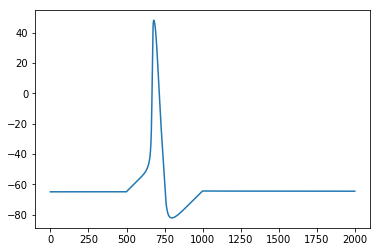

In [6]:
voltage = mon.v[0]/mV
# voltage += np.random.randn(len(voltage))
plot(voltage)

In [7]:
inp_trace = np.array([input_current])
n0, n1 = inp_trace.shape
inp_trace.shape

(1, 1497)

In [8]:
out_trace = np.array([voltage[:n1]])
out_trace.shape

(1, 1497)

## AdEx

In [46]:
start_scope()

In [47]:
# Parameters
C = 171 * pF
# gL = 60 * nS
gL = 6.16243899e-08*siemens
taum = C / gL
EL = -65 * mV
VT = -50.4 * mV
DeltaT = 5 * mV
Vcut = VT + 50 * DeltaT

In [48]:
taum

2.77487534 * msecond

In [49]:
# Pick an electrophysiological behaviour
tauw, a, b, Vr = 124*ms, 4*nS, 0.0805*nA, -70.6*mV # Regular spiking (as in the paper)


In [50]:
eqs = """
dvm/dt = (gL*(EL - vm) + gL*DeltaT*exp((vm - VT)/DeltaT) + I(t) - w)/C : volt
dw/dt = (a*(vm - EL) - w)/tauw : amp
"""

In [51]:
neuron = NeuronGroup(1, model=eqs, threshold='vm>Vcut',
                     reset="vm=Vr; w+=b", method='exponential_euler')
neuron.vm = EL
trace = StateMonitor(neuron, 'vm', record=0)
spikes = SpikeMonitor(neuron)

In [52]:
run(30*ms)

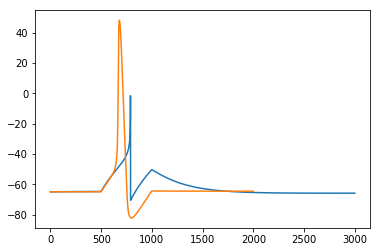

In [53]:
plot(trace[0].vm/mV)
plot(voltage);

## Model Fitting

In [39]:
eqs = Equations(
"""
taum = C / gL : second
dvm/dt = (gL*(EL - vm) + gL*DeltaT*exp((vm - VT)/DeltaT) + I - w)/C : volt
dw/dt = (a*(vm - EL) - w)/tauw : amp
gL: siemens(constant)
""", 
# C: farad (constant)
C = 171 * pF,
# gL = 60 * nS,
EL = -65 * mV,
VT = -50.4 * mV,
DeltaT = 5 * mV,
Vcut = VT + 50 * DeltaT,    
tauw = 144*ms,
a = 4*nS,
b = 0.0805*nA,
Vr = -70.6*mV)



In [40]:
gL/siemens

6.000000000000001e-08

In [42]:
start_scope()
n_opt = NevergradOptimizer(method='PSO')
metric = MSEMetric()

res, error = fit_traces_standalone(model=eqs, input_var='I', output_var='vm',
                                   input=inp_trace * amp, output=out_trace*mV, dt=dt,
                                   method='exponential_euler',
                                   gL=[59 * nS, 62 * nS],
#                                    C=[170*pF, 172*pF],
                                   n_rounds=1, n_samples=20, optimizer=n_opt, metric=metric)

d {'gL': array([6.16243899e-08, 6.17220479e-08, 6.10619551e-08, 6.00091324e-08,
       6.16356163e-08, 6.04555116e-08, 6.05692724e-08, 5.96265537e-08,
       5.91685001e-08, 5.91930502e-08, 6.02089563e-08, 6.09776719e-08,
       5.90721048e-08, 5.91835686e-08, 6.11930327e-08, 6.10084297e-08,
       5.95536305e-08, 6.14019256e-08, 5.91587626e-08, 6.03709926e-08])}
out [[0.00000000e+00 4.28939374e-19 7.75949130e+18 ...            nan
             nan            nan]
 [0.00000000e+00 4.29617901e-19 8.90134751e+18 ...            nan
             nan            nan]
 [0.00000000e+00 4.25031506e-19 3.51904952e+18 ...            nan
             nan            nan]
 ...
 [0.00000000e+00 4.27393680e-19 5.67555196e+18 ...            nan
             nan            nan]
 [0.00000000e+00 4.11806933e-19 2.42117429e+17 ...            nan
             nan            nan]
 [0.00000000e+00 4.20230437e-19 1.33191388e+18 ...            nan
             nan            nan]] EV
errors [nan nan nan nan nan

In [43]:
res

{'gL': 5.900000000000001e-08}

In [44]:
error

array([], dtype=float64)

In [67]:
inp_trace[0][900:1200]

array([2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09,
       2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09,
       2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09,
       2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09,
       2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09,
       2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09,
       2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09,
       2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09,
       2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09,
       2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09,
       2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09,
       2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09, 2.e-09,
       2.e-09, 2.e-09, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
       0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
      

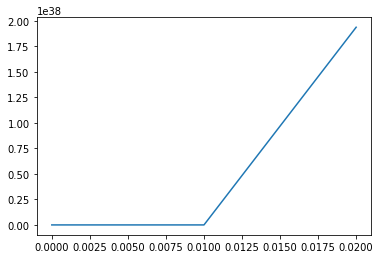

In [45]:
fits = generate_fits(model=eqs, method='exponential_euler', params=res,
                     input=inp_trace * amp, input_var='I', output_var='vm',
                     dt=dt)


plot(np.arange(len(fits[0]))*dt/ms, fits[0]/mV);
